# Project in Machine Learning Class: Predict user's product reviews sentiment
---

### John Koumentis, MTN2012

The project evaluates the performance of different Machine Learning Classification algorithms over predicting the correct sentiment (Positive or Negative) of the given review in **Greek** language.

In [1]:
# Load the necessary modules
import numpy as np
import pandas as pd
from collections import Counter
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and pre-process data
---

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset
if os.path.exists('20191226-reviews.csv'):
    df = pd.read_csv('20191226-reviews.csv')
else:
    df = pd.read_csv('https://drive.google.com/uc?id=1jwYbSTB4m0LaWKl0UCxcWLiJdLHpsnFX&export=download')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
#reviews_dataset.to_csv('reviews.csv')
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


After removing the lines containing the empty reviews and creating a new dataset by keeping only the reviews and ratings column, the reviews column was loaded in XLSX format at https://translate.google.gr/?hl=el&sl=auto&tl=el&op=docs and translated. The output was an HTML table that was launched via Excel and stored in CSV format with name 'translate.csv'.

In [7]:
if os.path.exists('translated.csv'):
    translated = pd.read_csv('translated.csv',header=None)
else:
    translated = pd.read_csv('https://drive.google.com/uc?id=1Jr4Mvh4V4xtR6_47jIIyJ8N6pebunmni&export=download',
                         header=None)
reviews_dataset.insert(loc=1, column='greek', value=translated)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,3
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,1
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",5
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",3
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,4
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",4
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,5
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",4
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",5
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",3


Introducing a function to clean the translated text, that converts words to lowercase, removes punctuation and stopwords and applies lemmatization.

In [8]:
#Clean reviews text
punctuation = set(string.punctuation)
greek = re.compile(r'[α-ωά-ώϊϋΐΰ]+') #Isolate greek characters
special_chars = re.compile('[u"\U0001F300-\U0001F5FF"]+',flags=re.UNICODE) #Locate special characters like emojis
nlp = spacy.load('el_core_news_sm')

def clean_text(text):
    """Accepts a string a input and applies a cleaning pipeline,
       converting to lowercase, removing special characters, punctuation
       and stopwords and performing lemmatization.
       The output is the cleaned input string.
    """
    # Convert the text into lowercase
    text = text.lower()
    # Remove special characters
    text = special_chars.sub(r'',text)
    # Remove Latin characters
    wordList = greek.findall(text)
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punctuation)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('greek')]
    # Lemmatisation
    cleaned_text = nlp(" ".join(wordList))
    cleaned_text = [token.lemma_ for token in cleaned_text]
    return " ".join(cleaned_text).strip()

Due to long execution time the results of the following cell execution were stored in the cleaned.csv file, to get retrieved directly from there.

In [9]:
#start = time.process_time()
#reviews_dataset['cleaned_text'] = reviews_dataset['greek'].apply(clean_text)
#print(time.process_time() - start)
#reviews_dataset.to_csv('cleaned.csv')
if os.path.exists('cleaned.csv'):
    reviews_dataset = pd.read_csv('cleaned.csv')
else:
    reviews_dataset = pd.read_csv('https://drive.google.com/uc?id=1I9_zVYFblWO4uYP3-WsIkV-RPdsUMx2o&export=download',
                              index_col=0)

<AxesSubplot:xlabel='ratings', ylabel='count'>

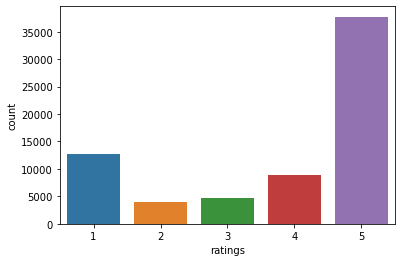

In [10]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

The `4` and `5` star (positive) ratings combined are more than the `1`,`2` ones (negative) combined. Hence, I decided to add the `3` star ratings to the negative ratings. In order to simplify the situation, I replaced the `4`,`5` star ratings with the label `1`, to indicate positive sentiment and the `1`,`2`,`3` star ratings with the label `0`, to indicate negative sentiment.

In [11]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
reviews_dataset.head(10)

,Unnamed: 0,reviews,greek,ratings,cleaned_text
0,0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,0,έχω λίγο είναι απόλυτος μπορείτε διαβάσω κριτι...
1,1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,0,λόγω ενός προβλήματος λογισμικός μεταξύ της τη...
2,2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",1,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...
3,3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",0,λατρεύω τηλέφωνο όλος γιατί πραγματικά χρειαζά...
4,4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,1,τηλέφωνο ήταν τέλειος κάθε σκοπό προσφέρω εκτό...
5,5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",1,γει σας έχω αυτό τηλέφωνο χρησιμοποίησα μέχρι ...
6,6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,1,δροσερός φτηνό χρώμα λέξει περιγράφω τέλειο θέ...
7,7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",1,είναι γενικά ένα ωραίος τηλέφωνο εκτός από ότι...
8,8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",1,έχω ποτέ προηγουμένως τηλέφωνο γι αυτό είναι π...
9,9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",0,εντάξω είμαι σχολείο χρειάζομαι γραπτά μηνύμαα...


<AxesSubplot:xlabel='ratings', ylabel='count'>

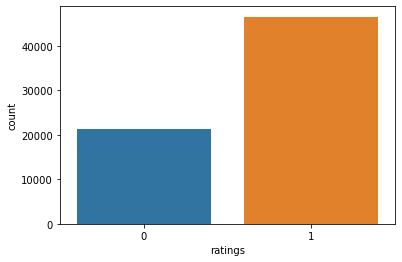

In [12]:
sns.countplot(reviews_dataset['ratings'])

After cleaning the data, there were some reviews that provided empty result:

In [13]:
missing_data = reviews_dataset.isnull().sum()
print(missing_data)

Unnamed: 0         0
reviews            0
greek              0
ratings            0
cleaned_text    2145
dtype: int64


In [14]:
nans = np.where(pd.isnull(reviews_dataset.cleaned_text))
reviews_dataset.drop(list(nans)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [15]:
#Isolate cleaned text and ratings columns in a new dataset
reviews = pd.DataFrame({'reviews':reviews_dataset.cleaned_text.values, 'ratings':reviews_dataset.ratings.values})
#reviews_dataset.to_csv('reviews.csv')
reviews.head()

,reviews,ratings
0,έχω λίγο είναι απόλυτος μπορείτε διαβάσω κριτι...,0
1,λόγω ενός προβλήματος λογισμικός μεταξύ της τη...,0
2,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...,1
3,λατρεύω τηλέφωνο όλος γιατί πραγματικά χρειαζά...,0
4,τηλέφωνο ήταν τέλειος κάθε σκοπό προσφέρω εκτό...,1


In [16]:
greek_reviews = reviews.reviews
labels = reviews.ratings

## Check Positive and Negative usage of words
---

In [17]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [18]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    try:
        for word in greek_reviews[i].split(" "):
            total_counts[word] += 1
            if labels[i] == 1:
                positive_counts[word] += 1
            else:
                negative_counts[word] += 1
    except KeyError:
        pass

In [19]:
pos_neg_ratios = Counter()
pos_neg_ratios_log = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratios[term] = positive_counts[term] / float(negative_counts[term]+1)
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios_log[word] = np.log(ratio)

In [20]:
print("Pos-to-neg ratio for 'λόγω' = {}".format(pos_neg_ratios_log["λόγω"]))
print("Pos-to-neg ratio for 'υπέροχο' = {}".format(pos_neg_ratios_log["υπέροχο"]))
print("Pos-to-neg ratio for 'απογοητευμένος' = {}".format(pos_neg_ratios_log["απογοητευμένος"]))

Pos-to-neg ratio for 'λόγω' = 0.2786746254947829
Pos-to-neg ratio for 'υπέροχο' = 2.2204814395004866
Pos-to-neg ratio for 'απογοητευμένος' = -1.526315069184163


Neutral words like 'λόγω' have logarithmic pos-to-neg ratio slightly larger than zero. Positive words like 'υπέροχο' logarithmic ratio is larger than `1`, that means it is used mostly in positive reviews, whereas negative words like 'απογοητευμένος' have a ratio value smaller than `-1` indicating that they are used mostly in negative reviews.

In [21]:
dict(pos_neg_ratios_log.most_common()[0:20])

{'εξοχο': 4.6913478822291435,
 'δουλευει': 4.518158808998462,
 'τελεια': 3.9815490680767565,
 'νικήσω': 3.373026504695459,
 'αγαπω': 3.0845277723371223,
 'αναμενόμενο': 2.842969519001581,
 'οπως': 2.8247744754103516,
 'λατρεύω': 2.8073137365199687,
 'δύσπισ': 2.659260036932778,
 'ανεπιφύλακτα': 2.59239256475814,
 'προσιτός': 2.5734600471294455,
 'ερωτευμένος': 2.533696813957432,
 'ομαλό': 2.51939282585917,
 'αγαπά': 2.509599262378372,
 'διστακτικός': 2.477302050402781,
 'αγαπήστε': 2.4010251658072983,
 'εξαιρετικό': 2.4008047889620023,
 'δύσπιστος': 2.3978952727983707,
 'συνιστάται': 2.346436975522895,
 'τέλειος': 2.3249521231409416}

In [22]:
dict(pos_neg_ratios_log.most_common()[-20:])

{'προσπάθησε': -1.6029653979284828,
 'δυσαρεστημένος': -1.6156684621847366,
 'επικοινώνησα': -1.6218604324326575,
 'ελαττωματικός': -1.626315950221452,
 'σκουπιδιής': -1.661884387806643,
 'επισκευάσω': -1.6711314814394402,
 'σταματά': -1.6761292869327726,
 'απογοητευμένο': -1.7033903187779649,
 'σταμάτησε': -1.7482743572883161,
 'επιστροφός': -1.7975298256893915,
 'μητρικός': -1.8827312474337816,
 'τυχαίας': -1.906169820405799,
 'άχρηστο': -1.9102410728485784,
 'χρημάτα': -1.9554681668614187,
 'ελαττωματικό': -1.9830278120118159,
 'απενεργοποιείται': -2.0149030205422647,
 'επισκευή': -2.1486794811743857,
 'απάτη': -2.149311221640322,
 'σπατάλη': -2.468099531471619,
 'αγορασω': -2.6026896854443837}

As a final preparation step, the tf-idf vectorizer was used to transform the words in vectors according to their frequency and importance. As it is mentioned at the [corresponding scikit learn documentation topic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html), the goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [23]:
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform([reviews.reviews[0]])
print(vectorized[0,0:20])

  (0, 11)	0.04845015831115092
  (0, 9)	0.04845015831115092
  (0, 6)	0.04845015831115092
  (0, 18)	0.04845015831115092
  (0, 15)	0.04845015831115092
  (0, 3)	0.04845015831115092
  (0, 0)	0.04845015831115092
  (0, 14)	0.04845015831115092
  (0, 1)	0.04845015831115092
  (0, 19)	0.04845015831115092
  (0, 10)	0.04845015831115092
  (0, 2)	0.04845015831115092
  (0, 12)	0.04845015831115092
  (0, 16)	0.04845015831115092
  (0, 8)	0.04845015831115092
  (0, 17)	0.04845015831115092
  (0, 4)	0.04845015831115092
  (0, 13)	0.04845015831115092
  (0, 7)	0.04845015831115092
  (0, 5)	0.14535047493345277


## Machine Learning Pipeline
---

In order to feed the classifiers with data, the dataset is brought to the form X,y, where X is the column that contains the text reviews and y the column that contains the target sentiment values.

In [24]:
tfidfvectorizer = TfidfVectorizer()
X = tfidfvectorizer.fit_transform(reviews['reviews'])
y = reviews['ratings']

In [25]:
def model_training(X,y,classifier,balanced=False):
    """Training Pipeline implementation. The function accepts as input a feature matrix,
       a target values vector and a classifier. The performance is tested via a 20 fold validation procedure.
       The model average training and testing time and several classification algorithms metrics are produced.
       Returns the trained model, along with a dictionary of the produced metrics
    """    
    metrics_dict = {}
    n_splits = 10
    #print classifier
    print('########## Using',str(classifier),'classifier ##########\n')
    
    if balanced:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    else:
        kf = KFold(n_splits=n_splits, shuffle=False, random_state=None)
    
    average_training_time = 0.0
    average_testing_time = 0.0
    best_accuracy = 0.0
    average_accuracy = 0.0
    average_f1_score = 0.0
    best_f1_score = 0.0
    selected_clf = None
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_clf = classifier
        training_time_start = time.process_time()
        model_clf.fit(X_train,y_train)
        training_time = time.process_time() - training_time_start
        average_training_time += training_time/n_splits
        testing_time_start = time.process_time()
        # Form predictions using test set
        predictions = model_clf.predict(X_test)
        testing_time = time.process_time() - testing_time_start
        average_testing_time += testing_time/n_splits
        # Calculate the overall accuracy
        accuracy = metrics.accuracy_score(y_test, predictions)
        average_accuracy += accuracy/n_splits
        # Calculate F1 Score
        f1_score = metrics.f1_score(y_test,predictions)
        average_f1_score += f1_score/n_splits
        if accuracy > best_accuracy and f1_score > best_f1_score: 
            selected_clf = model_clf
            best_accuracy = accuracy
            best_f1_score = f1_score

    metrics_dict['Average training time'] = average_training_time
    print('Average training time: ',average_training_time)
    
    metrics_dict['Average testing time'] = average_testing_time
    print('Average testing time: ',average_testing_time,'\n')

    metrics_dict['Accuracy'] = average_accuracy
    metrics_dict['F1 Score'] = average_f1_score
    print('Average accuracy: {}\nAverage F1-Score: {}\n\n'.format(average_accuracy, average_f1_score))
    
    print('---------------------------------------------------------------------------------')
    return selected_clf, metrics_dict

Four classifiers from different implementation categories, were tested against the input data, the ***Multinomial Naive Bayes classifier***, a ***Support Vector Classifier with linear kernel***, a ***Logistic Regression classifier with 1000 maximum itrerations*** and a ***Decision Tree Classifier with maximum depth set to 10***, to avoid overfitting.

In [26]:
text_nb, nb_metrics = model_training(X,y,MultinomialNB())
text_svm, svm_metrics = model_training(X,y,LinearSVC())
text_lr, lr_metrics = model_training(X,y,LogisticRegression(max_iter=1000))
text_dt, dt_metrics = model_training(X,y,DecisionTreeClassifier(max_depth=10))

########## Using MultinomialNB() classifier ##########

Average training time:  0.0171875
Average testing time:  0.0015625 

Average accuracy: 0.8454725007596474
Average F1-Score: 0.8940401374241641


---------------------------------------------------------------------------------
########## Using LinearSVC() classifier ##########

Average training time:  0.5390625
Average testing time:  0.0 

Average accuracy: 0.8821634761470678
Average F1-Score: 0.9135978725402251


---------------------------------------------------------------------------------
########## Using LogisticRegression(max_iter=1000) classifier ##########

Average training time:  6.996875
Average testing time:  0.0 

Average accuracy: 0.8866150106350653
Average F1-Score: 0.9174612738498278


---------------------------------------------------------------------------------
########## Using DecisionTreeClassifier(max_depth=10) classifier ##########

Average training time:  4.678125
Average testing time:  0.004687500000000

### Balance positive and negative reviews and re-train
---
As the positive reviews were a lot more than the negative ones, below is an attempt to balance it by keeping the same count of positive and negative reviews.

In [27]:
reviews['ratings'].value_counts()

1    44740
0    21080
Name: ratings, dtype: int64

In [28]:
majority = reviews[reviews.ratings == 1]
minority = reviews[reviews.ratings == 0]
downsampled_majority = resample(majority,replace=False, n_samples=len(minority), random_state=77)

reviews_downsampled = pd.concat([downsampled_majority, minority])
reviews_downsampled.reset_index(inplace=True)
reviews_downsampled['ratings'].value_counts()

1    21080
0    21080
Name: ratings, dtype: int64

In [29]:
tfidfvectorizer_downsampled = TfidfVectorizer()
X_downsampled = tfidfvectorizer_downsampled.fit_transform(reviews_downsampled['reviews'].values.astype('U'))
y_downsampled = reviews_downsampled['ratings']

In [30]:
text_nb_downsampled, nb_downsampled_metrics = model_training(X_downsampled,y_downsampled,MultinomialNB(),True)
text_svm_downsampled, svm_downsampled_metrics = model_training(X_downsampled,y_downsampled,LinearSVC(),True)
text_lr_downsampled, lr_downsampled_metrics = model_training(X_downsampled,y_downsampled,LogisticRegression(max_iter=1000),True)
text_dt_downsampled, dt_downsampled_metrics = model_training(X_downsampled,y_downsampled,DecisionTreeClassifier(max_depth=10),True)

########## Using MultinomialNB() classifier ##########

Average training time:  0.0109375
Average testing time:  0.003125 

Average accuracy: 0.8592030360531308
Average F1-Score: 0.8581022462882931


---------------------------------------------------------------------------------
########## Using LinearSVC() classifier ##########

Average training time:  0.32500000000000007
Average testing time:  0.0 

Average accuracy: 0.8739800759013283
Average F1-Score: 0.8733375148158116


---------------------------------------------------------------------------------
########## Using LogisticRegression(max_iter=1000) classifier ##########

Average training time:  3.3671874999999996
Average testing time:  0.00625 

Average accuracy: 0.8749762808349145
Average F1-Score: 0.8732919470657559


---------------------------------------------------------------------------------
########## Using DecisionTreeClassifier(max_depth=10) classifier ##########

Average training time:  2.971875
Average testing t

In [31]:
learners = {'Naive Bayes':text_nb, 
            'Naive Bayes (Downsampled)':text_nb_downsampled,
            'SVM':text_svm,
            'SVM (Downsampled)':text_svm_downsampled,
            'Logistic Regression':text_lr,
            'Logistic Regression (Downsampled)':text_lr_downsampled,
            'Decision Tree':text_dt,
            'Decision Tree (Downsampled)':text_dt_downsampled
           }
metrics_dict = {'Naive Bayes':nb_metrics, 
            'Naive Bayes (Downsampled)':nb_downsampled_metrics,
            'SVM':svm_metrics,
            'SVM (Downsampled)':svm_downsampled_metrics,
            'Logistic Regression':lr_metrics,
            'Logistic Regression (Downsampled)':lr_downsampled_metrics,
            'Decision Tree':dt_metrics,
            'Decision Tree (Downsampled)':dt_downsampled_metrics
           }

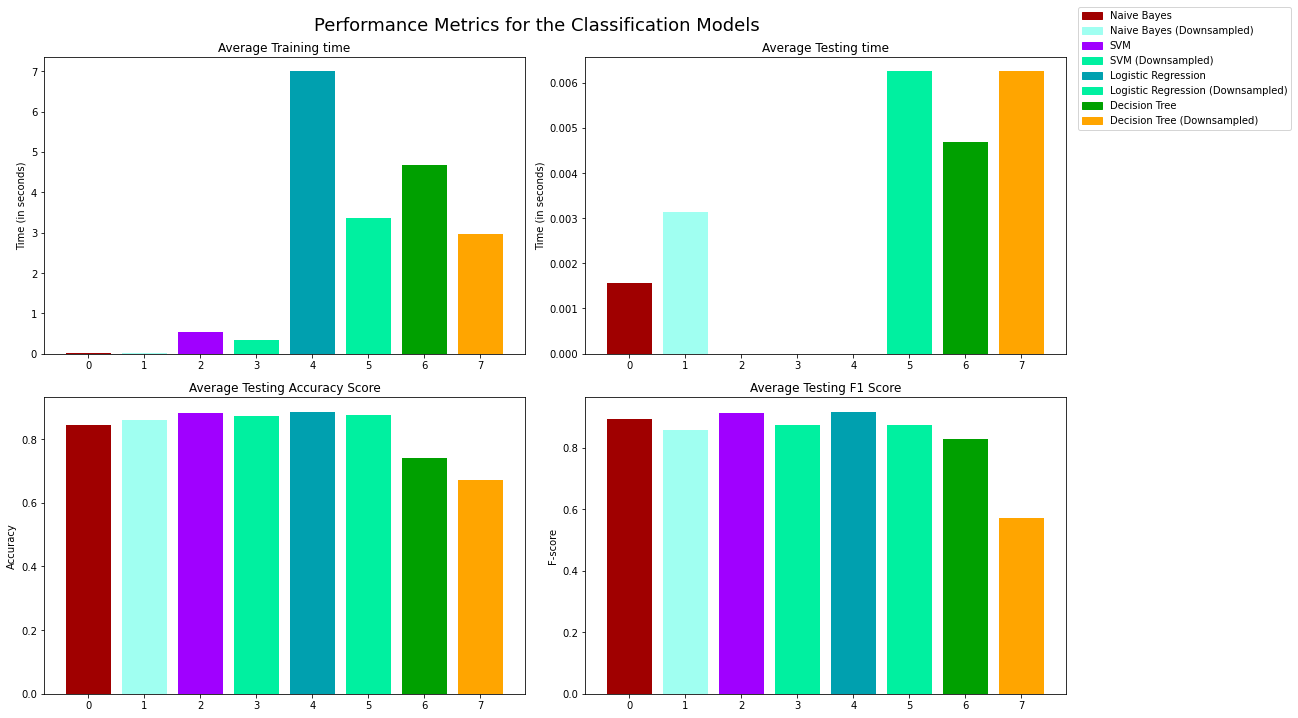

In [32]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))
colors = ['#A00000','#A0FFF1','#A000FF','#00F0A0',
          '#00A0AF','#00F0A0','#00A000','#FFA500',
          '#BFA500','#DFA500','#FFF500','#FFAFF0']

for k, learner in enumerate(learners.keys()):
    for j, metric in enumerate(['Average training time','Average testing time','Accuracy','F1 Score']):
        ax[j//2, j%2].bar(k, metrics_dict[learner][metric],color = colors[k])
            
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 0].set_title("Average Training time")

ax[0, 1].set_ylabel("Time (in seconds)")
ax[0, 1].set_title("Average Testing time")

ax[1, 0].set_ylabel("Accuracy")
ax[1, 0].set_title("Average Testing Accuracy Score")

ax[1, 1].set_ylabel("F-score")
ax[1, 1].set_title("Average Testing F1 Score")


patches = []
for i, learner in enumerate(learners.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
fig.legend(handles = patches, loc='upper center', bbox_to_anchor=(1.1, 1), ncol = 1, fontsize = 'medium')

plt.suptitle("Performance Metrics for the Classification Models", fontsize = 18)
plt.tight_layout()
plt.show()

Comparing overall performance, lowest training and testing time and highest average accuracy and f1 scores, the Linear SVC classifier will be the selected one.

### Hyperparameter tuning
---

In [33]:
def hyperparam_tuning(X,y,classifier):
    """Tune the selected classifier's hypeparameters"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
    
    default_model = classifier
    default_model.fit(X_train,y_train)
    prediction = default_model.predict(X_test)
    
    hyperparameters = {"C": [0.01, 0.1, 1.0, 10.0, 100.0],
                       "loss": ['hinge', 'square-hinge'],
                       "dual": [True, False],
                       "fit_intercept": [True, False],
                       "class_weight": ['balanced',None]}

    scorer = metrics.make_scorer(metrics.f1_score)
    grid_search = GridSearchCV(classifier,hyperparameters,scorer,n_jobs=-1)
    grid_fit = grid_search.fit(X_train,y_train)
    best_model = grid_fit.best_estimator_    
    best_prediction = best_model.predict(X_test)
    
    print('Unoptimized Model\nAccuracy: {}\nF1 Score: {}'.format(metrics.accuracy_score(y_test,prediction),
                                                                 metrics.f1_score(y_test,prediction)))
    print('Hyperparameters: C: {}, Loss: {}, Dual: {}, Fit-Intercept: {} Class Weigth: {}\n'.format(default_model.C,default_model.loss,
                                                                                   default_model.dual,default_model.fit_intercept,
                                                                                                   default_model.class_weight))
    print('Best Model\nAccuracy: {}\nF1 Score: {}'.format(metrics.accuracy_score(y_test,best_prediction),
                                                                 metrics.f1_score(y_test,best_prediction)))
    print('Hyperparameters: C: {}, Loss: {}, Dual: {}, Fit_Intercept: {} Class Weigth: {}\n'.format(best_model.C,best_model.loss,
                                                                                   best_model.dual,best_model.fit_intercept,
                                                                                                   best_model.class_weight))
    print('---------------------------------------------------------------------------------')
    
    return best_model

In [34]:
text_svc = hyperparam_tuning(X,y,LinearSVC())
text_svc_downsampled = hyperparam_tuning(X_downsampled,y_downsampled,LinearSVC())

Unoptimized Model
Accuracy: 0.8807605543022881
F1 Score: 0.9131455399061033
Hyperparameters: C: 1.0, Loss: squared_hinge, Dual: True, Fit-Intercept: True Class Weigth: None

Best Model
Accuracy: 0.8866995073891626
F1 Score: 0.9175792893265012
Hyperparameters: C: 1.0, Loss: hinge, Dual: True, Fit_Intercept: True Class Weigth: None

---------------------------------------------------------------------------------
Unoptimized Model
Accuracy: 0.871055847049522
F1 Score: 0.8692610406646262
Hyperparameters: C: 1.0, Loss: squared_hinge, Dual: True, Fit-Intercept: True Class Weigth: None

Best Model
Accuracy: 0.8735714799108747
F1 Score: 0.8723419696639815
Hyperparameters: C: 1.0, Loss: hinge, Dual: True, Fit_Intercept: False Class Weigth: None

---------------------------------------------------------------------------------


### Check prediction in reviews from https://www.skroutz.gr
---

In [35]:
def data_extraction(url,reviews_selector,ratings_selector):
    """Accepts a URL and the respective CSS selectors
       of the reviews text and rating.
       Returns the extracted data in a Pandas dataframe.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    reviews = soup.select(reviews_selector)
    ratings = soup.select(ratings_selector)
    rlist = []
    for i in range(len(reviews)):
        rlist.append([reviews[i].text,ratings[i].text])
    data = pd.DataFrame(rlist,columns=['reviews','sentiment'])
    sentiment_dict = {'1':0, '2':0, '3':0, '4':1, '5':1}
    data['sentiment'].replace(sentiment_dict,inplace=True)
    data['reviews'] = data['reviews'].apply(clean_text)
    return data

Classifier trained with imbalanced dataset:

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.93      0.93      0.93        27

    accuracy                           0.87        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.87      0.87      0.87        30

Average confidence score:  1.0036831519321472


Classifier trained with balanced dataset:

              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.92      0.85      0.88        27

    accuracy                           0.80        30
   macro avg       0.56      0.59      0.57        30
weighted avg       0.85      0.80      0.82        30

Average confidence score:  0.9603485637441395


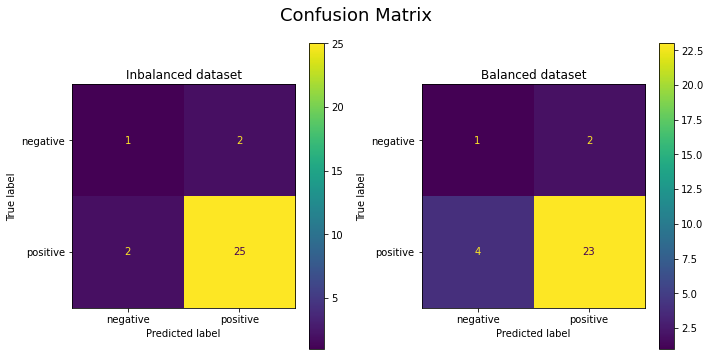

In [36]:
url = 'https://www.skroutz.gr/s/20060269/Apple-iPhone-11-64GB-Black.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)

vectorized_data = tfidfvectorizer.transform(data['reviews'])
vectorized_data_downsampled = tfidfvectorizer_downsampled.transform(data['reviews'])

average_confidence = np.sum(np.sum(text_svc.decision_function(vectorized_data)))/len(text_svc.decision_function(vectorized_data))
average_confidence_downsampled = np.sum(np.abs(text_svc_downsampled.decision_function(vectorized_data_downsampled)))/len(text_svc_downsampled.decision_function(vectorized_data_downsampled))

print('Classifier trained with imbalanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc.predict(vectorized_data)))
print('Average confidence score: ',average_confidence)
print('\n\nClassifier trained with balanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc_downsampled.predict(vectorized_data_downsampled)))
print('Average confidence score: ',average_confidence_downsampled)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
confusion_matrix = metrics.plot_confusion_matrix(text_svc,vectorized_data,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[0])

ax[0].set_title('Inbalanced dataset')
confusion_matrix_downsampled = metrics.plot_confusion_matrix(text_svc_downsampled,vectorized_data_downsampled,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[1])

ax[1].set_title('Balanced dataset')
plt.suptitle("Confusion Matrix", fontsize = 18)
plt.tight_layout()

Classifier trained with imbalanced dataset:

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.83      0.91      0.87        22

    accuracy                           0.80        30
   macro avg       0.75      0.70      0.72        30
weighted avg       0.79      0.80      0.79        30

Average confidence score:  0.7506966297810287


Classifier trained with balanced dataset:

              precision    recall  f1-score   support

           0       0.47      0.88      0.61         8
           1       0.93      0.64      0.76        22

    accuracy                           0.70        30
   macro avg       0.70      0.76      0.68        30
weighted avg       0.81      0.70      0.72        30

Average confidence score:  0.860272786215683


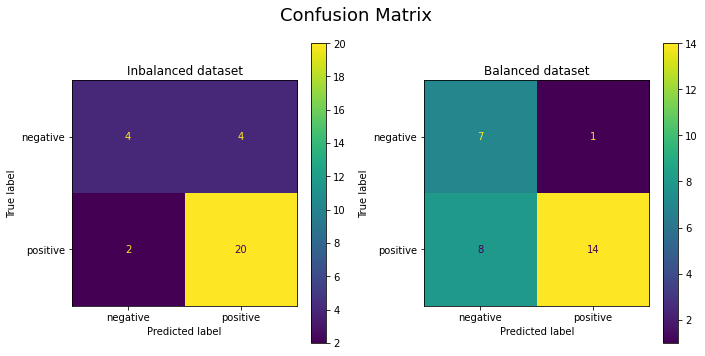

In [37]:
url = 'https://www.skroutz.gr/s/23272388/Xiaomi-Redmi-Note-9-Pro-128GB-Tropical-Green.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)

vectorized_data = tfidfvectorizer.transform(data['reviews'])
vectorized_data_downsampled = tfidfvectorizer_downsampled.transform(data['reviews'])

average_confidence = np.sum(np.sum(text_svc.decision_function(vectorized_data)))/len(text_svc.decision_function(vectorized_data))
average_confidence_downsampled = np.sum(np.abs(text_svc_downsampled.decision_function(vectorized_data_downsampled)))/len(text_svc_downsampled.decision_function(vectorized_data_downsampled))

print('Classifier trained with imbalanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc.predict(vectorized_data)))
print('Average confidence score: ',average_confidence)
print('\n\nClassifier trained with balanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc_downsampled.predict(vectorized_data_downsampled)))
print('Average confidence score: ',average_confidence_downsampled)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
confusion_matrix = metrics.plot_confusion_matrix(text_svc,vectorized_data,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[0])

ax[0].set_title('Inbalanced dataset')
confusion_matrix_downsampled = metrics.plot_confusion_matrix(text_svc_downsampled,vectorized_data_downsampled,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[1])

ax[1].set_title('Balanced dataset')
plt.suptitle("Confusion Matrix", fontsize = 18)
plt.tight_layout()

Classifier trained with imbalanced dataset:

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.90      0.82      0.86        22

    accuracy                           0.80        30
   macro avg       0.75      0.78      0.76        30
weighted avg       0.82      0.80      0.81        30

Average confidence score:  0.44528868049104453


Classifier trained with balanced dataset:

              precision    recall  f1-score   support

           0       0.46      0.75      0.57         8
           1       0.88      0.68      0.77        22

    accuracy                           0.70        30
   macro avg       0.67      0.72      0.67        30
weighted avg       0.77      0.70      0.72        30

Average confidence score:  0.6279122760940546


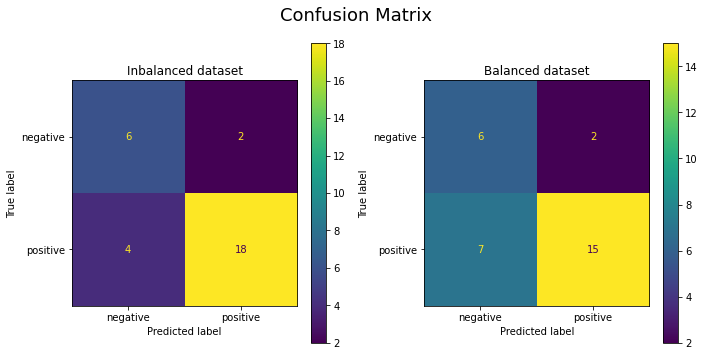

In [38]:
url = 'https://www.skroutz.gr/s/23290197/Samsung-Galaxy-S20-Ultra-5G-128GB-Cloud-White.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)

vectorized_data = tfidfvectorizer.transform(data['reviews'])
vectorized_data_downsampled = tfidfvectorizer_downsampled.transform(data['reviews'])

average_confidence = np.sum(np.sum(text_svc.decision_function(vectorized_data)))/len(text_svc.decision_function(vectorized_data))
average_confidence_downsampled = np.sum(np.abs(text_svc_downsampled.decision_function(vectorized_data_downsampled)))/len(text_svc_downsampled.decision_function(vectorized_data_downsampled))

print('Classifier trained with imbalanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc.predict(vectorized_data)))
print('Average confidence score: ',average_confidence)
print('\n\nClassifier trained with balanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc_downsampled.predict(vectorized_data_downsampled)))
print('Average confidence score: ',average_confidence_downsampled)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
confusion_matrix = metrics.plot_confusion_matrix(text_svc,vectorized_data,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[0])

ax[0].set_title('Inbalanced dataset')
confusion_matrix_downsampled = metrics.plot_confusion_matrix(text_svc_downsampled,vectorized_data_downsampled,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[1])

ax[1].set_title('Balanced dataset')
plt.suptitle("Confusion Matrix", fontsize = 18)
plt.tight_layout()

Classifier trained with imbalanced dataset:

              precision    recall  f1-score   support

           0       0.14      0.50      0.22         2
           1       0.96      0.79      0.86        28

    accuracy                           0.77        30
   macro avg       0.55      0.64      0.54        30
weighted avg       0.90      0.77      0.82        30

Average confidence score:  0.4977198579632497


Classifier trained with balanced dataset:

              precision    recall  f1-score   support

           0       0.08      0.50      0.14         2
           1       0.94      0.61      0.74        28

    accuracy                           0.60        30
   macro avg       0.51      0.55      0.44        30
weighted avg       0.89      0.60      0.70        30

Average confidence score:  0.6726791030234629


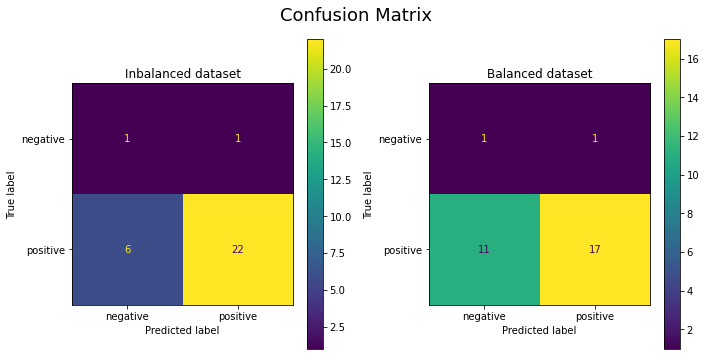

In [39]:
url = 'https://www.skroutz.gr/s/12247000/Gigabyte-GeForce-GT-1030-2GB-OC-GV-N1030OC-2GI.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)

vectorized_data = tfidfvectorizer.transform(data['reviews'])
vectorized_data_downsampled = tfidfvectorizer_downsampled.transform(data['reviews'])

average_confidence = np.sum(np.sum(text_svc.decision_function(vectorized_data)))/len(text_svc.decision_function(vectorized_data))
average_confidence_downsampled = np.sum(np.abs(text_svc_downsampled.decision_function(vectorized_data_downsampled)))/len(text_svc_downsampled.decision_function(vectorized_data_downsampled))

print('Classifier trained with imbalanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc.predict(vectorized_data)))
print('Average confidence score: ',average_confidence)
print('\n\nClassifier trained with balanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc_downsampled.predict(vectorized_data_downsampled)))
print('Average confidence score: ',average_confidence_downsampled)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
confusion_matrix = metrics.plot_confusion_matrix(text_svc,vectorized_data,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[0])

ax[0].set_title('Inbalanced dataset')
confusion_matrix_downsampled = metrics.plot_confusion_matrix(text_svc_downsampled,vectorized_data_downsampled,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[1])

ax[1].set_title('Balanced dataset')
plt.suptitle("Confusion Matrix", fontsize = 18)
plt.tight_layout()

Classifier trained with imbalanced dataset:

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.85      0.92      0.88        24

    accuracy                           0.80        30
   macro avg       0.67      0.62      0.64        30
weighted avg       0.78      0.80      0.78        30

Average confidence score:  0.6445559865816418


Classifier trained with balanced dataset:

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         6
           1       0.83      0.62      0.71        24

    accuracy                           0.60        30
   macro avg       0.54      0.56      0.52        30
weighted avg       0.72      0.60      0.64        30

Average confidence score:  0.6875041627853583


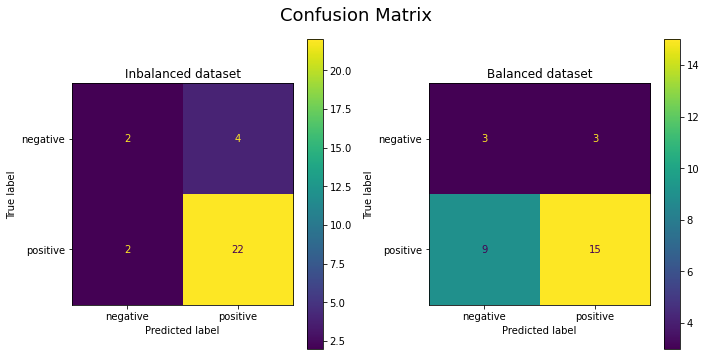

In [40]:
url = 'https://www.skroutz.gr/s/5281582/Adidas-Stan-Smith-M20325.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)

vectorized_data = tfidfvectorizer.transform(data['reviews'])
vectorized_data_downsampled = tfidfvectorizer_downsampled.transform(data['reviews'])

average_confidence = np.sum(np.sum(text_svc.decision_function(vectorized_data)))/len(text_svc.decision_function(vectorized_data))
average_confidence_downsampled = np.sum(np.abs(text_svc_downsampled.decision_function(vectorized_data_downsampled)))/len(text_svc_downsampled.decision_function(vectorized_data_downsampled))

print('Classifier trained with imbalanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc.predict(vectorized_data)))
print('Average confidence score: ',average_confidence)
print('\n\nClassifier trained with balanced dataset:\n')
print(metrics.classification_report(data['sentiment'],text_svc_downsampled.predict(vectorized_data_downsampled)))
print('Average confidence score: ',average_confidence_downsampled)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
confusion_matrix = metrics.plot_confusion_matrix(text_svc,vectorized_data,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[0])

ax[0].set_title('Inbalanced dataset')
confusion_matrix_downsampled = metrics.plot_confusion_matrix(text_svc_downsampled,vectorized_data_downsampled,data['sentiment'],
                                                 display_labels=['negative','positive'],ax=ax[1])

ax[1].set_title('Balanced dataset')
plt.suptitle("Confusion Matrix", fontsize = 18)
plt.tight_layout()